# CHAPTER 3 - KERAS PREPROCESSING & LAYERS

## Import

In [1]:
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import text_to_word_sequence, one_hot, hashing_trick, Tokenizer
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator, pad_sequences, skipgrams, make_sampling_table

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GRU

import numpy as np

## Keras preprocessing API

### 1 - Sequence Generator

#### 1 - 1 Time Series Generator

Let's go with a toy time series dataset of 10 integer values.

In [ ]:
# define toy time series dataset
series = np.array([i for i in range(10)])
series

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

We want to predict the next value from the last five lag observations. So, we define a Generator with the length argument setted to 5. This argument specifies the length of the output sequences in number of timesteps.



In [ ]:
# define generator
generator = TimeseriesGenerator(data = series, 
                                targets = series, 
                                length=5, 
                                batch_size=1,
                                shuffle=False,
                                reverse=False)

We want to generate samples composed of five lag observations for one prediction and the toy time series dataset contains 10 values.

So the number of samples generated is 5.

In [ ]:
# number of samples
print('Samples: %d' % len(generator))

Samples: 5


Display the inputs and output of each sample and check that the data are well prepared.

In [ ]:
for i in range(len(generator)):
	x, y = generator[i]
	print('%s => %s' % (x, y))

[[0 1 2 3 4]] => [5]
[[1 2 3 4 5]] => [6]
[[2 3 4 5 6]] => [7]
[[3 4 5 6 7]] => [8]
[[4 5 6 7 8]] => [9]


Then, we create and compile a model.

In [ ]:
# define model
model = Sequential()
model.add(Dense(10, activation='relu', input_dim=5))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

And we train the model by giving the generator as input data.

In [ ]:
model.fit(generator, epochs=10)

Epoch 1/10
5/5 [==============================] - 0s 3ms/step - loss: 38.7968
Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 35.2142
Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 31.6144
Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 27.9557
Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 24.8539
Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 22.2239
Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 19.4684
Epoch 8/10
5/5 [==============================] - 0s 2ms/step - loss: 17.2211
Epoch 9/10
5/5 [==============================] - 0s 2ms/step - loss: 15.1597
Epoch 10/10
5/5 [==============================] - 0s 2ms/step - loss: 13.1092


#### 1 - 2 Padding

The `pad_sequences` function allows to easily truncate and pad sequences to a common length. 

Let's start with four sentences

In [ ]:
sentences = [["What", "do", "you", "like", "?"],
             ["I", "like", "basket-ball", "!"],
             ["And", "you", "?"],
             ["I", "like", "coconut", "and", "apple"]]

After vocabulary lookup, the data are encoded as integer vectors:

In [ ]:
text_set = set(np.concatenate(sentences))
vocab_to_int = dict(zip(text_set, range(len(text_set))))
int_to_vocab = {vocab_to_int[word]:word for word in vocab_to_int.keys()}

In [ ]:
encoded_sentences = []
for sentence in sentences:
    encoded_sentence = [vocab_to_int[word] for word in sentence]
    encoded_sentences.append(encoded_sentence)
encoded_sentences

[[8, 4, 7, 6, 0], [5, 6, 2, 3], [10, 7, 0], [5, 6, 1, 9, 11]]

Then pad variable length sequences. The pre-sequence padding is activated by default.

In [ ]:
pad_sequences(encoded_sentences)

array([[ 8,  4,  7,  6,  0],
       [ 0,  5,  6,  2,  3],
       [ 0,  0, 10,  7,  0],
       [ 5,  6,  1,  9, 11]], dtype=int32)

Activate the post-sequence padding and set the `maxlen` argument to the desired length, here 7.

In [ ]:
pad_sequences(encoded_sentences, maxlen = 7)

array([[ 0,  0,  8,  4,  7,  6,  0],
       [ 0,  0,  0,  5,  6,  2,  3],
       [ 0,  0,  0,  0, 10,  7,  0],
       [ 0,  0,  5,  6,  1,  9, 11]], dtype=int32)

The length of the sequence can also be trimmed to a desired length, here 3.

By default, this function removes timesteps from the beginning of each sequence.

In [ ]:
pad_sequences(encoded_sentences, maxlen = 3)

array([[ 7,  6,  0],
       [ 6,  2,  3],
       [10,  7,  0],
       [ 1,  9, 11]], dtype=int32)

Set the `truncating` argument to `post' for removing timesteps from the end of each sequence.

In [ ]:
pad_sequences(encoded_sentences, maxlen = 3, truncating='post')

array([[ 8,  4,  7],
       [ 5,  6,  2],
       [10,  7,  0],
       [ 5,  6,  1]], dtype=int32)

#### 1 - 3 Skipgrams

First, encode a sentence as a list of word indices and then call the `skip_grams` function. 

In [ ]:
sentence = "I like coconut and apple"
encoded_sentence = [vocab_to_int[word] for word in sentence.split()]
vocabulary_size = len(encoded_sentence)
pairs, labels = skipgrams(encoded_sentence, 
                          vocabulary_size, 
                          window_size=1,
                          negative_samples=0)


Print the results.

In [ ]:
for i in range(len(pairs)):
    print("({:s} , {:s} ) -> {:d}".format(
          int_to_vocab[pairs[i][0]], 
          int_to_vocab[pairs[i][1]], 
          labels[i]))

(coconut , and ) -> 1
(apple , ! ) -> 0
(and , coconut ) -> 1
(apple , and ) -> 1
(coconut , do ) -> 0
(like , I ) -> 1
(and , apple ) -> 1
(like , coconut ) -> 1
(coconut , do ) -> 0
(I , like ) -> 1
(coconut , like ) -> 1
(and , do ) -> 0
(like , coconut ) -> 0
(I , ! ) -> 0
(like , ! ) -> 0
(and , coconut ) -> 0


### 2 - Text Generator


#### 2 - 1 Text to word sequence

Convert a sentence into a list of words

If `lower` argument is set to False, the text isn't converted into lower case.

In [4]:
sentence = "I like coconut , I like apple"
text_to_word_sequence(sentence, lower=False)

['I', 'like', 'coconut', 'I', 'like', 'apple']

If `lower` argument is set to True, the text is converted into lower case. 

In this example, we remove all the predefined filters.

In [5]:
text_to_word_sequence(sentence, lower=True, filters=[])

['i', 'like', 'coconut', ',', 'i', 'like', 'apple']

#### 2 - 2 One-Hot Encoding

Keras Preprocessing API offers an One-Hot function but it doesn’t follow the standard one-hot encoding definition. 

This function returns a list of integers where each integer encodes a word.

The unicity of word to index mapping is non-guaranteed.


In [8]:
print(sentence)
one_hot(sentence, 5)

I like coconut , I like apple


[3, 1, 3, 3, 1, 2]

This function is a wrapper to the `hashing_trick` function using hash as the hashing function. 
Feel free to upgrade the vocabulary size in order to decrease the number of possible collisions.


In [9]:
print(sentence)
one_hot(sentence, 15)

I like coconut , I like apple


[5, 1, 5, 5, 1, 8]

#### 2 - 3 Hashing Trick

The hashing-trick function converts a text to a sequence of indexes in a fixed-size hashing space. 

This function encodes and tokenizes a text like the one_hot encoding function.

By default, the `hash` function is used like in the one_hot encoding function.

In [ ]:
hashing_trick(sentence, 10)

[7, 5, 1, 1, 5, 1, 8, 7, 1, 4]

Here, we specify the md5 built in function.

In [ ]:
hashing_trick(sentence, 10, hash_function='md5')

[9, 4, 3, 6, 9, 4, 9, 5, 6, 7]

#### 2 - 4 Tokenizer

In [4]:
sentences = [["What", "do", "you", "like", "?"],
             ["I", "like", "basket-ball", "!"],
             ["And", "you", "?"],
             ["I", "like", "coconut", "and", "apple"]]
sentences

[['What', 'do', 'you', 'like', '?'],
 ['I', 'like', 'basket-ball', '!'],
 ['And', 'you', '?'],
 ['I', 'like', 'coconut', 'and', 'apple']]

In [6]:
# create the tokenizer
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(sentences)

Print the dictionary containing for each word their counts


In [7]:
print(t.word_counts)

OrderedDict([('what', 1), ('do', 1), ('you', 2), ('like', 3), ('?', 2), ('i', 2), ('basket-ball', 1), ('!', 1), ('and', 2), ('coconut', 1), ('apple', 1)])


Print the dictionary containing for each word the number of documents in which it appears


In [8]:
print(t.document_count)

4


Print the dictionary containing for each word its unique integer identifier

In [9]:
print(t.word_index)

{'like': 1, 'you': 2, '?': 3, 'i': 4, 'and': 5, 'what': 6, 'do': 7, 'basket-ball': 8, '!': 9, 'coconut': 10, 'apple': 11}


Print the number of unique documents that were used to fit the Tokenizer

In [10]:
print(t.word_docs)

defaultdict(<class 'int'>, {'do': 1, 'like': 3, 'what': 1, 'you': 2, '?': 2, '!': 1, 'basket-ball': 1, 'i': 2, 'and': 2, 'coconut': 1, 'apple': 1})


Now, we are ready to encode our documents thanks to the texts_to_matrix function. This function provides several bag-of-words method in order to compute the coefficient for each token.
Each document is encoded as a 11-element vector with one position for each word.

In [ ]:
print(len(t.word_index))
print("Binary")
encoded_sentences = t.texts_to_matrix(sentences, mode='binary')
print(encoded_sentences)
print("Word Count")
encoded_sentences = t.texts_to_matrix(sentences, mode='count')
print(encoded_sentences)
print("TF-IDF")
encoded_sentences = t.texts_to_matrix(sentences, mode='tfidf')
print(encoded_sentences)
print("Freq")
encoded_sentences = t.texts_to_matrix(sentences, mode='freq')
print(encoded_sentences)

11
Binary
[[0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1.]]
Word Count
[[0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1.]]
TF-IDF
[[0.         0.69314718 0.84729786 0.84729786 0.         0.
  1.09861229 1.09861229 0.         0.         0.         0.        ]
 [0.         0.69314718 0.         0.         0.84729786 0.
  0.         0.         1.09861229 1.09861229 0.         0.        ]
 [0.         0.         0.84729786 0.84729786 0.         0.84729786
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.69314718 0.         0.         0.84729786 0.84729786
  0.         0.         0.         0.         1.09861229 1.09861229]]
Freq
[[0.         0.2        0.2        0.2        0.         0.
  0.2        0.2        0.         0.         0.         0. 

### Image Generator

Let’s put theory into action and make out a data image augmentation on CIFAR10 dataset:

In [31]:
# Load CIFAR10 Dataset
(x_cifar10_train, y_cifar10_train), (x_cifar10_test, y_cifar10_test) = tf.keras.datasets.cifar10.load_data()

In [32]:
# Preprocess the data - Normalization
x_cifar10_train = x_cifar10_train[:30000]
x_cifar10_test = x_cifar10_test

y_cifar10_train = y_cifar10_train[:30000]

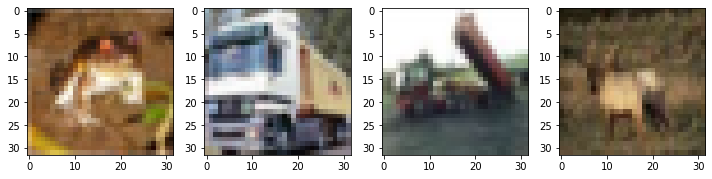

In [33]:
# Display 5 images before transformation
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
n_cols = 4
for i in range(n_cols):
    plt.subplot(1, n_cols, i + 1)
    plt.imshow(x_cifar10_train[i])
plt.tight_layout()
plt.show()

In [34]:
# Create an image data generator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True)

In [35]:
# Add an iterator that will return one batch of augmented images for each iteration
it= datagen.flow(x_cifar10_train[:2], y_cifar10_train[:2], batch_size = 1)

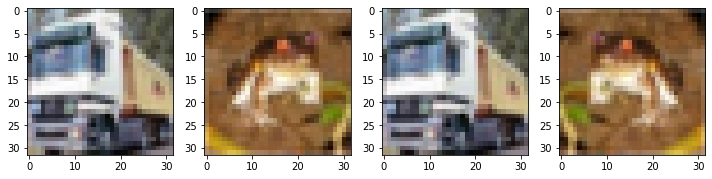

In [36]:
# Display 2 images after transformation and check if the flip is working correctly
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
n_cols = 4
for i in range(n_cols):
    plt.subplot(1, n_cols, i + 1)
    batch = it.next()
    image = tf.squeeze(batch[0])
    plt.imshow(np.uint8(image))
plt.tight_layout()
plt.show()

In [37]:
# Create an image data generator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True)

In [38]:
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(x_cifar10_train)

In [39]:
# Create an iterator on the full dataset
it= datagen.flow(x_cifar10_train, y_cifar10_train, batch_size = 64)

In [26]:
# Input() is used to instantiate a Keras tensor.
inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(inputs)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(x)
x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
predictions = tf.keras.layers.Dense(10, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=predictions)

In [40]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(lr=0.01),
              metrics=["accuracy"])

The steps_per_epoch argument must specify the number of batches of samples comprising one epoch.

In [41]:
history = model.fit(it, epochs=3,
                    steps_per_epoch=len(x_cifar10_train) / 32, 
                    validation_data=(x_cifar10_test, y_cifar10_test))

Epoch 1/3
469/937 [==============>...............] - 16s 34ms/step - loss: 1.8922 - accuracy: 0.1004 - val_loss: 89.0944 - val_accuracy: 0.7084
